In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import torch.nn.functional as F

Dataset Class

In [2]:
# Dataset class
class PeachDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_train=True):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train  

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        if self.is_train:
            # For training, check both folders
            folder_name = 'Images_Label_1' if self.annotations.iloc[index, 1] == 1 else 'Images'
        else:
            # For validation, all images are in the 'Images' folder 
            folder_name = 'Images'
        
        img_path = os.path.join(self.root_dir, folder_name, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB
        label = int(self.annotations.iloc[index, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transformations for the training dataset
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize 
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with standard ImageNet mean and std
])

# Transformations for the validation dataset
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size for your CNN
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with standard ImageNet mean and std
])

# Create the training dataset and data loader
train_dataset = PeachDataset(
    csv_file='C:/Users/nxity/Downloads/MEng Data Science/Deep Learning/Peaches/Peaches/Train/labels.csv', 
    root_dir='C:/Users/nxity/Downloads/MEng Data Science/Deep Learning/Peaches/Peaches/Train', 
    transform=train_transforms,
    is_train=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Create the validation dataset and data loader
val_dataset = PeachDataset(
    csv_file='C:/Users/nxity/Downloads/MEng Data Science/Deep Learning/Peaches/Peaches/Val/labels.csv',
    root_dir='C:/Users/nxity/Downloads/MEng Data Science/Deep Learning/Peaches/Peaches/Val',
    transform=val_transforms,
    is_train=False
)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [3]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layer (sees 128x128x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Convolutional layer (sees 64x64x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Convolutional layer (sees 32x32x32 tensor)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Linear layer (64 * 16 * 16 = 16384)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        # Linear layer (512 -> 2)
        self.fc2 = nn.Linear(512, 2)
        # Dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten image input
        x = x.view(-1, 64 * 16 * 16)
        # dropout layer
        x = self.dropout(x)
        # 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

Epoch: 1 	Training Loss: 0.388232 	Validation Loss: 0.277266
Epoch: 2 	Training Loss: 0.260374 	Validation Loss: 0.238519
Epoch: 3 	Training Loss: 0.244827 	Validation Loss: 0.237249
Epoch: 4 	Training Loss: 0.249919 	Validation Loss: 0.222768
Epoch: 5 	Training Loss: 0.234966 	Validation Loss: 0.206922
Epoch: 6 	Training Loss: 0.227627 	Validation Loss: 0.218591
Epoch: 7 	Training Loss: 0.220137 	Validation Loss: 0.250820
Early stopping triggered.
Accuracy: 0.9264705882352942
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       252
           1       0.91      0.90      0.90       156

    accuracy                           0.93       408
   macro avg       0.92      0.92      0.92       408
weighted avg       0.93      0.93      0.93       408



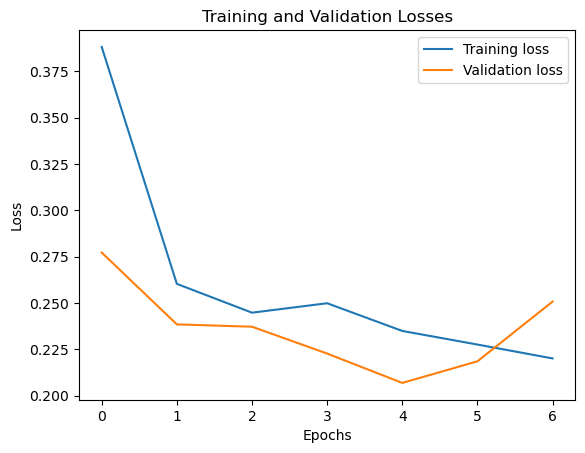

In [4]:
# Instantiate the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
n_epochs = 10
early_stopping_patience = 2
best_val_loss = float('inf')
train_losses = []
valid_losses = []

# Initialize the early stopping counter
early_stopping_counter = 0

for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model for evaluation
best_model = SimpleCNN()
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Evaluate the model
true_labels = []
predictions = []
with torch.no_grad():
    for data, target in val_loader:
        output = best_model(data)
        _, preds = torch.max(output, 1)
        predictions.extend(preds.tolist())
        true_labels.extend(target.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(true_labels, predictions))

# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

***Predict and Provide labels for the test set***

In [5]:
import os
import pandas as pd

# Path to the test images and where to save the predictions
test_images_path = 'C:/Users/nxity/Downloads/MEng Data Science/Deep Learning/Peaches/Peaches/Test/Images'
predictions_file_path = 'C:/Users/nxity/Downloads/MEng Data Science/Deep Learning/Peaches/Peaches/Test/Prediction_Labels.csv'

# Load the best model
best_model = SimpleCNN()
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Prepare the test dataset (without labels)
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

# Transformation for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the test dataset and data loader
test_dataset = TestDataset(root_dir=test_images_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Generate predictions
predictions = []
with torch.no_grad():
    for data, file_name in test_loader:
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        predictions.append((file_name[0], predicted.item()))

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, columns=['image_path', 'label'])
predictions_df.to_csv(predictions_file_path, index=False)

print(f"Predictions saved to {predictions_file_path}")

Predictions saved to C:/Users/nxity/Downloads/MEng Data Science/Deep Learning/Peaches/Peaches/Test/Prediction_Labels.csv
